
# Machine learning (ML) approaches to perform automatic annotation of cell types based on single cell RNA-sequencing data

### Dataset information:

The dataset used is a subset of the 68k PBMC dataset, containing 4 different cell-types. The cells are 
already annotated with their cell-types, under .obs['cell-types'], which will provide the labels for training models. The details on how the cells were originally annotated can be found in the original dataset paper: https://www.nature.com/articles/ncomms14049.

The full 68k PBMC dataset with all cell-types was downloaded from: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/fresh_68k_pbmc_donor_a/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz

Supplemental Papers
- https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1795-z
- https://link.springer.com/article/10.1186/s13059-021-02480-2


For scRNA-seq data, over 30 analysis types and more than 700 software programs are available. These programs are written in different languages, most commonly in R and Python. For updated information about the scRNA-seq analysis software collection, refer to scRNAtool website, https://www.scrna-tools.org/. 

#  Part 1: Single cell data, preprocessing and clustering

## 1. Setting Up
### 1.1 Annotated data object 


Single cell data has multiple layers of information, not just the large gene expression matrix. Often, the expression matrix is ~1000 times larger than a traditional RNA-seq dataset. Additional layers, for example, include information about the cell type of each cell, the sequencing experiment condition (batch), genes and gene groups, and various dimensionality reduction matrices, or even images of the tissues where the single cells were extracted. To handle all information in one Python object, the Theis's Lab has developed Anndata object structure, with the aim to provide a common framework for various Python-based software to work with single cell data.

<p align="center">
  <img src="https://falexwolf.de/img/scanpy/anndata.svg" alt="AnnData Structure" width="500" height="338" />
</p>



The diagram above describes the structure of an AnnData object. AnnData stores four main slots (layers): 1) a gene expression matrix .X, 2) annotations of cells .obs, 3) annotation of genes .var,  and 4) unstructured annotations .uns. Each component has one or several datatypes.

## 2. The PBMC dataset

To get a good feel of scRNAseq data and key analysis types, we will use a 'small' dataset with 2,700 Peripheral Blood Mononuclear Cells (PBMC). The PBMC dataset has well-characterised immune cell types. This dataset has been used by researchers around the world as one of the gold-standard dataset for the development and comparison of new analysis methods. 

In [ ]:
#manually download the PBMC dataset (7.3 MB)
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write
## LOAD THE DATA

In [2]:
# Environment setup; succesful loading here should mean all dependencies correctly installed #
import numpy as np
import pandas as pd
import scanpy as sc

from scipy import stats as sp
from scipy.cluster.hierarchy import dendrogram

import seaborn as sbn
import matplotlib.pyplot as plt

from gprofiler import GProfiler

from natsort import natsorted
from sklearn.cluster import AgglomerativeClustering

In [3]:
# Suppress warnings for tidy representation of the notebook   
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def print_msg(msg_lst: list, sep='\t', color='\033[91m'):
    msg = ""
    for i in msg_lst:
        msg += str(i) + sep

    print(color + "-" * 80 + bcolors.ENDC)
    print(color + msg.center(80, ' ') + bcolors.ENDC)
    print(color + '-' * 80 + bcolors.ENDC)

### 2.1 Load the data 
The PBMC scRNA-seq dataset we are using in this portion of the assignment was captured using the 10x Genomics Chromium machine and sequenced on the Illumina NextSeq500. 10x Genomics is one of the leading companies for single-cell data generation, and their preliminary analysis software ('Cellranger') was used to perform the read demultiplexing (matching reads to their cell of origin using the cell barcode) and mapping the reads to the genome. The output from this pipeline is in three files which slot into the three main components of the AnnData object described above:
1. `barcodes.tsv`: cell barcodes, which go into `.obs`
2. `genes.tsv`: gene names, `.var`
3. `matrix.mtx`: the expression matrix, `.X`

Most scRNA-seq analysis pipelines provide methods to load these three files in one go. The one we'll use is from the [Scanpy](https://scanpy.readthedocs.io/en/stable/) package, which loads them straight into an Anndata object:

In [ ]:
pbmc = sc.read_h5ad('Group_4.h5ad')
print(pbmc)

# check the cell types
pbmc.obs["cell-types"].unique()

pbmc

AnnData object with n_obs × n_vars = 19409 × 32738
    obs: 'cell-types'
    var: 'gene_ids'


AnnData object with n_obs × n_vars = 19409 × 32738
    obs: 'cell-types'
    var: 'gene_ids'

#### Understanding our data

Single cell RNA-seq samples a low percentage of the total number of mRNAs within a cell. This results in what is referred to as a 'sparse matrix'; whereby the majority of values within the matrix are '0'.

In [ ]:
total_elements = pbmc.X.shape[0] * pbmc.X.shape[1]
non_zero_elements = (pbmc.X != 0).sum()  # Number of zero elements
zero_elements = total_elements - non_zero_elements


percentage_zeros = (zero_elements / total_elements) * 100
print(f"Percentage of zero values: {percentage_zeros:.2f}%")


expressed_in_all = np.all(pbmc.X.toarray() > 0, axis=0)
universally_expressed_gene_count = np.sum(expressed_in_all)
print(f"Number of universally expressed genes: {universally_expressed_gene_count}")


Percentage of zero values: 98.29%
Number of universally expressed genes: 0


## 3 Exploratory data analysis (Quality control)

Due to the high amounts of technical variation and noise seen in scRNA-seq data, it is essential to perform quality control (QC) analysis by examining the data and removing low quality cells and genes before any in-depth analysis to answer biological questions. In this section, we will go through common QC statistics and considerations used to identify the outlier and low quality cells and genes to exclude from downstream analysis. 

### 3.1 QC statistics at the cell level
The 10x scRNA-seq platform used for this dataset is a droplet-based method, which compartmentalises each cell into a separate oil droplet, and sequencing preparations (cell lysis, cDNA synthesis from the mRNA transcripts, barcoding transcripts with cell barcodes etc.) occur in each droplet separately. As a result, there is technical variation between cells. 

For example, some cells will appear to have more sequencing reads and/or detected genes than others. Cells with particularly low levels of mapped reads and genes are likely to be low-quality cells, or even droplets that contain a few stray transcripts, but no cell at all. 

Another common cell-level QC metric to look for is the proportion of reads mapped to mitochondrial and ribosomal genes. Unusually high levels of mitochondrial reads are indicative of cells that were stressed or dying when they were captured, often due to the experimental handling prior to capture. Ribosomal genes are highly expressed and high proportions of ribosomal reads could be due to failure to capture other expressed genes within the cell. 

Calculate the average total reads per cell, accurate to 2 decimal places

In [ ]:
# Create an observation metric info to add the total reads per cell
obs_metrics = pd.DataFrame(index=pbmc.obs_names) ## Get the identifiers

# Calculate the mean number of non-zero values per cell
print(round(pbmc.X.getnnz(axis = 1).mean(), 2))

559.31


In [ ]:
total_reads_per_cell = np.sum(pbmc.X, axis=1)
total_genes_per_cell = np.sum(pbmc.X > 0, axis=1)

correlation, _ = sp.pearsonr(total_reads_per_cell, total_genes_per_cell)

# Output the result
print(correlation)



[0.97177466]


We can also generate a plot to assess the co-variation in the total reads per cell and total genes detected per cell across the 2700 cells:

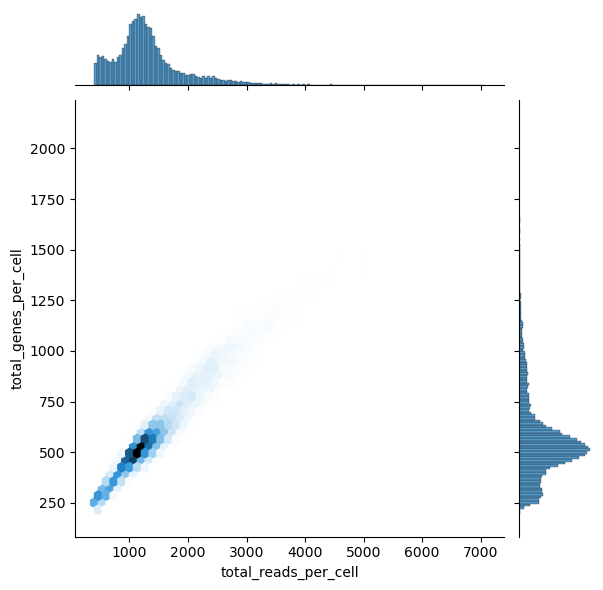

In [9]:
# add new QC metrics to the observation metric and write it to the pbmc AnnData object
#print(pbmc.obs)
obs_metrics["cell_types"] = pbmc.obs['cell-types']
obs_metrics["total_genes_per_cell"] = total_genes_per_cell
obs_metrics["total_reads_per_cell"] = total_reads_per_cell
pbmc.obs = obs_metrics

# plot
sbn.jointplot(data=pbmc.obs, x="total_reads_per_cell", y="total_genes_per_cell", kind="hex")

How many mitochondrial and ribosomal genes are detected in this dataset?

In [ ]:
print_msg(['Numer of Mt and Rb genes'], color=bcolors.OKBLUE)

print("Total Mt genes ", sum(pbmc.var_names.str.startswith('MT-'))) # Number of mitochondrial genes
print("Total Rb genes ", sum(pbmc.var_names.str.startswith(('RPL', 'RPS')))) # Number of ribosomal genes

--------------------------------------------------------------------------------
                           Numer of Mt and Rb genes	                            
--------------------------------------------------------------------------------
Total Mt genes  13
Total Rb genes  106


In [ ]:
#mito = np.sum(pbmc.var_names.str.startswith('MT-'), axis=1)
#ribo = np.sum(pbmc.var_names.str.startswith(('RPL', 'RPS')), axis=1)
ribo = pbmc.var_names.str.startswith('RPL', 'RPS')
print(ribo)

ribosomal_genes = pbmc.var_names.str.startswith(('RPS', 'RPL'))
print(ribosomal_genes)

ribosomal_reads_per_cell = np.sum(pbmc[:, ribosomal_genes].X, axis=1)
print(ribosomal_reads_per_cell)

print(len(ribosomal_reads_per_cell))
print(len(total_reads_per_cell))

percent_ribosomal_reads = (ribosomal_reads_per_cell / total_reads_per_cell) * 100
correlation, _ = sp.pearsonr(percent_ribosomal_reads, total_genes_per_cell)
print(correlation)


[False False False ... False False False]
[False False False ... False False False]
[[ 536.]
 [1008.]
 [ 430.]
 ...
 [ 525.]
 [ 779.]
 [ 438.]]
19409
19409
[-0.30556266]


In [ ]:
mito_genes = pbmc.var_names.str.startswith(('MT-'))
mito_reads_per_cell = np.sum(pbmc[:, mito_genes].X, axis=1)
percent_mito_reads = (mito_reads_per_cell / total_reads_per_cell) * 100

high_mito_cells = 0
for cell in percent_mito_reads:
    if cell > 5:
        high_mito_cells += 1

print(high_mito_cells)

#high_mito_cells = np.sum(percent_mito_reads > 0)
#print(high_mito_cells)


high_ribo_cells = 0
for cell in percent_ribosomal_reads:
    if cell > 50:
        high_ribo_cells += 1

print(high_ribo_cells)


116
747


### 3.2 QC at genes level 
So far, we have looked at the QC metrics for each cell, now we will examine metrics for genes. In scRNA-seq, lowly expressed genes can be missed by the PCR amplification during sequencing since they have very few transcript copies in the cell. This results in expressed genes showing up as zeros in the expression matrix. These genes' expression can be imputed, but it is also common to remove these genes as they can add noise to downstrem analysis. 

Example problem: How many genes are expressed in no cells?

In [ ]:
# get number of non-zero values in each row (gene) and add to annData object. 
pbmc.var['cells_per_gene'] = pbmc.X.getnnz(axis = 0) 
genes_in_no_cells = sum(pbmc.var['cells_per_gene'] == 0)
print('There are', genes_in_no_cells, 'genes expressed in no cells.')

There are 14585 genes expressed in no cells.


### 3.3 Removing cell and gene outliers 
So far we have examined the noise present in the data at both the cell and gene level, arising from experimental constraints and technical variation. Now we will look at how to remove that noise, and how much to remove. 

#### Removing poor quality cells 
A simple way to filter outlier cells is to use 'hard' thresholds to remove cells with too many genes or too high a proportion of mitochondrial or ribosomal genes (e.g., removing cells with more than 2500 genes, or more than 5% of mitochondrial reads). A better way to select thresholds is to use a dataset-dependent distribution to define the thresholds. 

When removing low quality or outlier cells, we must decide what is an acceptable amount of each QC metric - what proportion of mitochondrial reads is too much? How many detected genes is too few? A traditional way to filter cells is to select 'hard' thresholds (e.g., remove cells with more than 2500 genes, or more than 5% of mitochondrial reads), but a better way is to use the dataset-dependent distribution of QC metrics to define the thresholds. 

Here we use the median absolute deviation (MAD), calculated by the following formula: $MAD = median(|x-median(x)|)$.
If we use +/- 3 times the MAD as a range to define the lower and upper bounds, we can consistently remove outliers in any given dataset. We apply this method to filter total genes detected in each cell. Cells with fewer genes than the lower bound have low transcriptomic diversity, while cells with more maybe considered overabundant in the number of genes detected. 

In [ ]:
def mad(x):
    return np.median(abs(x - np.median(x)))

total_genes_per_cell = np.array(total_genes_per_cell)
med_genes_per_cell = np.median(total_genes_per_cell)
print(med_genes_per_cell)
mad_genes_per_cell = np.median(abs(total_genes_per_cell - med_genes_per_cell))
print(mad_genes_per_cell)

upper = med_genes_per_cell + 3 * mad_genes_per_cell
lower = med_genes_per_cell - 3 * mad_genes_per_cell

print(upper, lower)

count = 0
for cell in total_genes_per_cell:
    if cell > upper or cell < lower:
        count += 1

print(count, "cells outside the median +/- 3x MAX genes/cell range")

523.0
87.0
784.0 262.0
2938 cells outside the median +/- 3x MAX genes/cell range


Compare outlier cells with the remaing cells by using metrics like mitochondial and ribosomal reads, top abundant genes, and/or differentially expressed genes.

Number of cells after filtering cells:  16449


<Axes: xlabel='total_genes_per_cell', ylabel='Count'>

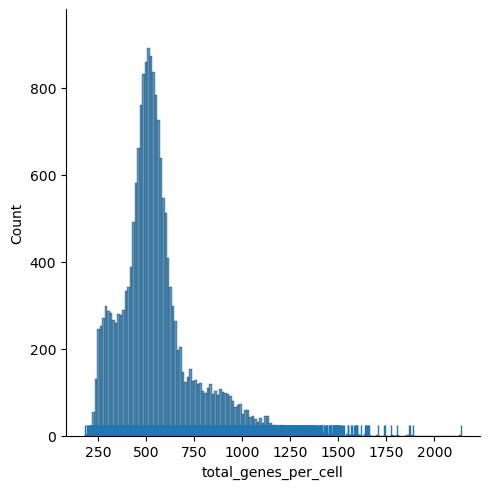

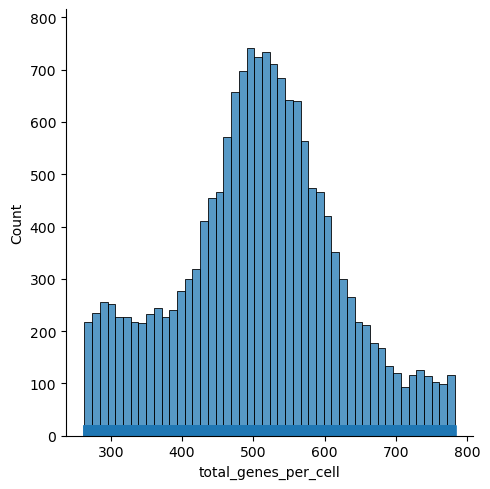

In [ ]:
# Before filtering cells 
sbn.displot(pbmc.obs.total_genes_per_cell)
sbn.rugplot(pbmc.obs.total_genes_per_cell)

# After filtering cells 
pbmc_filtered = pbmc[pbmc.obs.total_genes_per_cell > lower, :]
pbmc_filtered = pbmc_filtered[pbmc_filtered.obs.total_genes_per_cell < upper, :]
print('Number of cells after filtering cells: ', pbmc_filtered.shape[0])

# Check the effect of data preprocessing, notice the change to the normal distribution 
sbn.displot(pbmc_filtered.obs.total_genes_per_cell)
sbn.rugplot(pbmc_filtered.obs.total_genes_per_cell)

#### Removing unreliably detected genes
As we discovered earlier, many of the 32,738 genes are not expressed in any of the cells - these genes can be removed from downstream analysis. Likewise, genes expressed in only one cell are likely to arise from technical noise or transcriptional randomness. Analysis of these genes will not yield significant results and removal of noisy genes will make downstream analysis faster and more accurate (e.g. when scaling the dataset, noisy gene sare given the same weight as informative genes if they are retained in the data). 

For some cases, the lower bound calculated by the 3MAD formula is less than 0, so there is no point using it as a cutoff. We reason that for a gene to be reliably detected, it needs to be detected in at least three cells (at minimum in two cells), so we use a 'hard' cutoff of 3 cells in this case. Note that when selecting this limit, you must consider how big the smallest population you expect is, because you don't want to remove genes that are specific to real small cell populations in the dataset. 

We can see that the number of reliably-detected genes is much lower than the total number of genes that could possibly be mapped. This observation is reasonable, given that only a subset of all genes are active in any certain cell types.


In [16]:
print("Genes before filtering: ", pbmc.shape[1])
sc.pp.filter_genes(pbmc_filtered, min_cells=3)
print("Genes after filtering: ", pbmc_filtered.shape[1])

print(pbmc.shape)
print(pbmc_filtered.shape)

Genes before filtering:  32738
Genes after filtering:  14764
(19409, 32738)
(16449, 14764)


/Users/annabelgrosser/opt/anaconda3/envs/binf_A3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


## 4 Normalisation (between cells) 

In this dataset, there is only one sample (one experimental condition/replicate), so we won't go through between-sample normalisation, but we will still need to perform between-cell (within-sample) normalisation. As discussed earlier, the compartmentalisation of each cell into different droplets gives rise to technical variation between cells, which mostly affects the library size (total number of reads) for each cell. To combat this, we will scale the original data so that each cell has 10,000 reads, maintaining the distributionof gene abundance within each cell. This global scaling is a fast and simple way to perform cell-cell normalisation, however more accurate normalisation methods are available, for example the scran and scTransform algorithms.

### 4.1 Normalisation to a constant library size 

In [17]:
##### First, we cache the original counts in-case we need them later. Since some methods require raw counts.
# pbmc.layers['counts'] = pbmc.X.copy() # Important to copy so changes in pbmc.X don't effect pbmc.X['counts']
# pbmc.layers['counts'].toarray()

In [18]:
# X = pbmc.X.toarray() ###### Original version was pbmc.X; which is NOT a deep copy of the matrix, causing no change below!!
# reads_per_cells = pbmc.X.sum(axis=1)
# # set the total number of reads after scaling normalisation as 1e6 
# # (i.e. assuming every cell has the same number of reads mapped to the cells as 1e6 reads)
# after = 1e4
# counts = np.asarray(reads_per_cells)[:,0] # EDIT
# scale_factors = counts / after   # scale factor for each cell 

# # Calculating 'counts-per-million' normalisation of measurements between cells.
# X_cpt = np.apply_along_axis(np.divide, 0, X, scale_factors)

# reads_per_cells_norm = X_cpt.sum(axis=1)
# sp.describe(reads_per_cells_norm) # confirm that most cells have total reads ~1e4

In [19]:
# counts = X_cpt.sum(axis=1)
# print(min(counts), max(counts))

In [20]:
#### For reference, the above can be performed in one function using scanpy:
sc.pp.normalize_total(pbmc_filtered, target_sum=1e4)

### 4.2 Normalisation by median 

Section 4.1 above shows how one can normalise the dataset so that each cell has 10,000 reads per cell after normalisation. This approach is common, but is not always ideal because there are cases that some datasets have deeper sequencing and thus most cells may have more than 10,000 reads. In these cases, setting every cell to have 10,000 reads will lead to information loss.

Normalise by adjusting the total reads per cell to the median total reads per cell across all cells (using the newly calculated filtered data, counts).

In [21]:
# Your code here

#print(pbmc.layers["counts"])

# total_reads_per_cell = np.sum(pbmc.X, axis=1)

# median_total_reads = np.median(total_reads_per_cell)

# scale_factors = np.array(total_reads_per_cell / median_total_reads)
# scale_factors = scale_factors[0]
# print(scale_factors)
# print(len(scale_factors))
# count = 0
# for cell in scale_factors:
#     if cell > 1:
#         count += 1


# print(f"Number of cells with scale factors greater than 1: {count}")

'''

X = pbmc.X.toarray() ###### Original version was pbmc.X; which is NOT a deep copy of the matrix, causing no change below!!
reads_per_cells = pbmc.X.sum(axis=1)
# set the total number of reads after scaling normalisation as 1e6 
# (i.e. assuming every cell has the same number of reads mapped to the cells as 1e6 reads)
scale_factors = []
counts = np.asarray(reads_per_cells)[:,0] # EDIT
after = np.median(counts)
#print(after)
#print(counts)

scale_factors = []
i=0
for cell in counts:
    scale = cell / after
    i += 1
    scale_factors.append(scale)
    #print(scale)

count = 0
for scale in scale_factors:
    if scale > 1:
        count += 1

print(count)


# # Calculating 'counts-per-million' normalisation of measurements between cells.
X_cpt = np.apply_along_axis(np.divide, 0, X, scale_factors)

reads_per_cells_norm = X_cpt.sum(axis=1)

# reads_per_cells_norm = X_cpt.sum(axis=1)
sp.describe(reads_per_cells_norm) # confirm that most cells have total reads ~1e4

'''

"\n\nX = pbmc.X.toarray() ###### Original version was pbmc.X; which is NOT a deep copy of the matrix, causing no change below!!\nreads_per_cells = pbmc.X.sum(axis=1)\n# set the total number of reads after scaling normalisation as 1e6 \n# (i.e. assuming every cell has the same number of reads mapped to the cells as 1e6 reads)\nscale_factors = []\ncounts = np.asarray(reads_per_cells)[:,0] # EDIT\nafter = np.median(counts)\n#print(after)\n#print(counts)\n\nscale_factors = []\ni=0\nfor cell in counts:\n    scale = cell / after\n    i += 1\n    scale_factors.append(scale)\n    #print(scale)\n\ncount = 0\nfor scale in scale_factors:\n    if scale > 1:\n        count += 1\n\nprint(count)\n\n\n# # Calculating 'counts-per-million' normalisation of measurements between cells.\nX_cpt = np.apply_along_axis(np.divide, 0, X, scale_factors)\n\nreads_per_cells_norm = X_cpt.sum(axis=1)\n\n# reads_per_cells_norm = X_cpt.sum(axis=1)\nsp.describe(reads_per_cells_norm) # confirm that most cells have total 

### 4.3 Assess normalisation effects 

In [22]:
# Write the normalised matrix to pbmc object
# NOTE: using the 10,000 scaling factor, not the median total reads calculated in 4.2!

#pbmc.X = X_cpt
#sc.pp.normalize_total(pbmc, target_sum=1e4)

# print(pbmc.layers['counts'].min(), pbmc.layers['counts'].max())  # Raw counts layer
# print("Before log-scaling", pbmc.X.min(), pbmc.X.max())  # Normalized layer

# sc.pp.log1p(pbmc) #NOTE this adds a +1 pseudocount to prevent -infinity for log(0)
# # log-transform to reduce difference in magnitude between highly and lowly expressed genes
# print("After log-scaling", pbmc.X.min(), pbmc.X.max())  # Normalized layer



In [23]:
# # Visualise after normalisation 
# sbn.histplot(pbmc.X.sum(axis=1), discrete=False, legend=False)
# plt.title('After normalisation')

In [24]:
# You can restore the value before normalisation 
# sbn.histplot(pbmc.layers['counts'].sum(axis=1), discrete=True, legend=False)
# plt.title('Before normalisation')

In [25]:
# Comparing gene distribution before and after normalization
# sc.set_figure_params(figsize=(10, 7))

# fig, (ax1, ax2) = plt.subplots(1,2)
# gene='ACTB' # change gene name to see several genes 
# gene_expr = pbmc.layers['counts'][:,pbmc.var_names.values == gene].todense()
# sbn.histplot(gene_expr, 
#              legend=False, bins =100, ax = ax1)
# ax1.set_title('Before normalisation')

# gene_expr_after = pbmc.X[:,pbmc.var_names.values == gene].todense()
# sbn.histplot(gene_expr_after, 
#              legend=False, bins = 100,  ax = ax2)
# ax2.set_title('After normalisation')

# fig.suptitle(gene + ' expression')

In [26]:
# comparing gene distribution before and after normalization
# fig, (ax1, ax2) = plt.subplots(1,2)
# sbn.violinplot(gene_expr, 
#              legend=False,  inner="quartile",ax = ax1)
# ax1.set_title('Before normalisation')

# sbn.violinplot(gene_expr_after, 
#              legend=False, inner="quartile",  ax = ax2)
# ax2.set_title('After normalisation')

# fig.suptitle(gene + ' expression')

### Log-transformation
We also log-transform to reduce the difference in magnitude between highly and lowly expressed genes.

In [27]:
sc.pp.log1p(pbmc_filtered) #NOTE this adds a +1 pseudocount to prevent -infinity for log(0)

### Feature Selection
Not all genes have the same amount of information; typically more abundant genes are captured more reliably than less abundant genes. Including genes which just represent noise will result in non-meaningful clusters that represent technical variation, rather than biological variation. Armed with the knowledge that the variance (aka dispersion) will depend on the mean, typical scRNA-seq analysis includes selection of genes which have a much greater variance than would be expected given their mean. This suggests they have variation which is due to biological variation, rather than technical variation.

Below, genes with a much higher level of variation than expected given their mean are selected; these are known as 'highly variable genes'.

In [28]:
### Can read about the input for this command here
?sc.pp.highly_variable_genes

Signature:
sc.pp.highly_variable_genes(
    adata: 'AnnData',
    *,
    layer: 'str | None' = None,
    n_top_genes: 'int | None' = None,
    min_disp: 'float' = 0.5,
    max_disp: 'float' = inf,
    min_mean: 'float' = 0.0125,
    max_mean: 'float' = 3,
    span: 'float' = 0.3,
    n_bins: 'int' = 20,
    flavor: "Literal['seurat', 'cell_ranger', 'seurat_v3', 'seurat_v3_paper']" = 'seurat',
    subset: 'bool' = False,
    inplace: 'bool' = True,
    batch_key: 'str | None' = None,
    check_values: 'bool' = True,
) -> 'pd.DataFrame | None'
Docstring:
Annotate highly variable genes :cite:p:`Satija2015,Zheng2017,Stuart2019`.

Expects logarithmized data, except when `flavor='seurat_v3'`/`'seurat_v3_paper'`, in which count
data is expected.

Depending on `flavor`, this reproduces the R-implementations of Seurat
:cite:p:`Satija2015`, Cell Ranger :cite:p:`Zheng2017`, and Seurat v3 :cite:p:`Stuart2019`.

`'seurat_v3'`/`'seurat_v3_paper'` requires `scikit-misc` package. If you plan to use th

In [29]:
sc.pp.highly_variable_genes(pbmc_filtered)

In [30]:
print(pbmc_filtered.shape)
print(pbmc.shape)

(16449, 14764)
(19409, 32738)


Number of highly variable genes selected:  2320


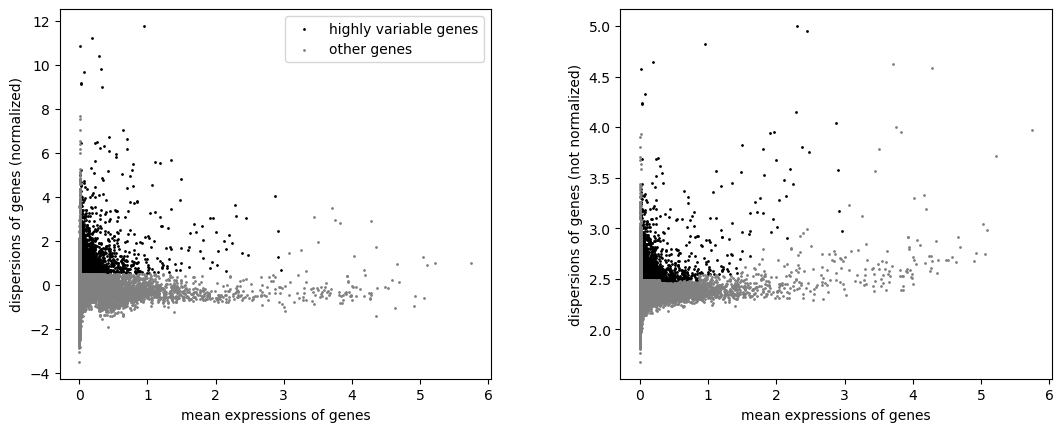

Highly variable genes have been written to highly_variable_genes.txt.


In [31]:
print("Number of highly variable genes selected: ", sum(pbmc_filtered.var['highly_variable'].values))
sc.pl.highly_variable_genes(pbmc_filtered)

# Get the list of highly variable genes
highly_variable_genes = pbmc_filtered.var[pbmc_filtered.var['highly_variable']].index.tolist()

# Specify the output file path
output_file_path = 'highly_variable_genes.txt'

# Write the list of highly variable genes to a text file
with open(output_file_path, 'w') as f:
    for gene in highly_variable_genes:
        f.write(f"{gene}\n")

print(f"Highly variable genes have been written to {output_file_path}.")

In [32]:
# Subset the AnnData object to only contain highly variable genes
pbmc_hvg = pbmc_filtered[:, highly_variable_genes].copy()  # Use .copy() to create a new AnnData object

# Check the shape of the new dataset to confirm
print(pbmc_hvg.shape)  # Should show (num_cells, num_highly_variable_genes)

(16449, 2320)


## 5 Dimensionality reduction 
Dimension reduction seeks to produce a low dimensional representation of high dimensional data that preserves relevant structure. Dimension reduction is needed in single cell data analysis for representation, noise reduction, faster computation and contributing to solving the “curse of dimensionality”. The “curse of dimensionality” refers to the fact that the number of observations (n) needed to estimate parameters (e.g. classification parameters in a logistic classifier for single cells) increases rapidly when the number of input variables (e.g. p genes or p dimensions) increases.

By analysis such as the Principal Component Analysis (PCA), each principal comnponent can be thought of as a 'metagene' or a latent (unseen, unknown) 'metafeature' that combines information across a correlated gene set or experimental/biological conditions. The use of the top principal components that explain most variation in the dataset can be considered as a way to compress/represent/simplify the dataset without loosing much information (i.e. preserving the data structure). 

### 5.1 Linear dimensionality reduction 

PCA applies orthogonal transformation to the initial Euclidean distance matrix derived from the full expression matrix containing all genes. The method creates low-dimensional embeddings that best preserves the overall variance of the dataset.

Before PCA, we will scale the data (also called standardization), so that the data structure won't be affected by just abundant genes. After scaling, each gene will have expression value with standard deviation equal 1 (by dividing each gene expression value for a cell by the standard deviation of that genes across all cells in a sample) and mean equal 0 (substract each gene expression value by the sample mean).


In [33]:
# NOTE that values are z-scored (x-mean(x)/std(x)) prior to PCA. 
# This is performed internally in sc.tl.pca. 
# This NEEDS to occur otherwise the features with higher mean will dominate.
sc.tl.pca(pbmc_hvg, svd_solver='arpack')

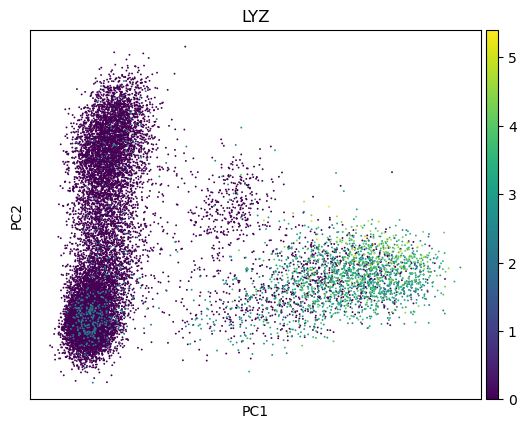

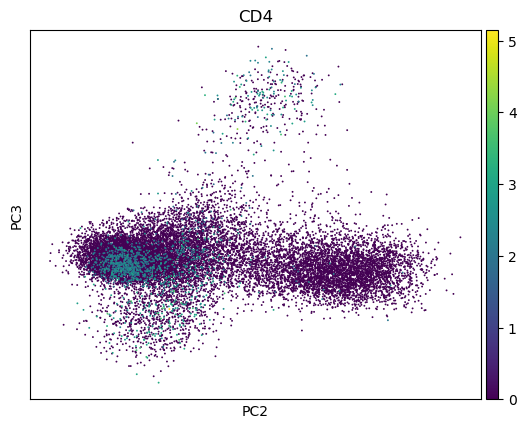

In [34]:
sc.pl.pca(pbmc_hvg, color='LYZ')
sc.pl.pca(pbmc_hvg, color='CD4', components='2,3')

Using normalised data (by total 1e4 reads/cell), what percentage of the variance in the dataset can be explained by the first 500 PCs (accurate to 2 decimal places)? 

In [35]:
#### Let's look at the PCA performed externally to scanpy, 
#### So we need to scale the data before inputting to sklearn.
?sc.pp.scale

Signature:
sc.pp.scale(
    data: 'AnnData | spmatrix | np.ndarray | DaskArray',
    *,
    zero_center: 'bool' = True,
    max_value: 'float | None' = None,
    copy: 'bool' = False,
    layer: 'str | None' = None,
    obsm: 'str | None' = None,
    mask_obs: 'NDArray[np.bool_] | str | None' = None,
) -> 'AnnData | spmatrix | np.ndarray | DaskArray | None'
Docstring:
Scale data to unit variance and zero mean.

.. note::
    Variables (genes) that do not display any variation (are constant across
    all observations) are retained and (for zero_center==True) set to 0
    during this operation. In the future, they might be set to NaNs.

Parameters
----------
data : 'AnnData | spmatrix | np.ndarray | DaskArray'
    The (annotated) data matrix of shape `n_obs` × `n_vars`.
    Rows correspond to cells and columns to genes.
zero_center : 'bool', optional (default: True)
    If `False`, omit zero-centering variables, which allows to handle sparse
    input efficiently.
max_value : 'float | N

In [ ]:

sc.pp.scale(pbmc_hvg)
print(pbmc_hvg)


sc.tl.pca(pbmc_hvg, n_comps=20, svd_solver='arpack') 

#print(pbmc_hvg.uns['pca'])

print(pbmc_hvg.varm['PCs'])

#print(pbmc_hvg.varm)

print(pbmc_hvg)

print(len(pbmc_hvg.varm['PCs']))

print(len(pbmc_hvg.varm['PCs'][0]))


cumulative_variance = np.sum(pbmc_hvg.uns['pca']['variance_ratio'][:500])
print(cumulative_variance)

reduced_matrix = pbmc_hvg.obsm['X_pca']  # (n_cells, 20)

print(reduced_matrix.shape)  # Should be (n_cells, 20)
print(type(reduced_matrix))



AnnData object with n_obs × n_vars = 16449 × 2320
    obs: 'cell_types', 'total_genes_per_cell', 'total_reads_per_cell'
    var: 'gene_ids', 'cells_per_gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
[[ 6.23284187e-03 -3.10476124e-03 -1.73916551e-03 ...  1.15496758e-02
   1.29349558e-02  5.01787141e-02]
 [ 5.92369549e-02 -3.02001592e-02  6.25477731e-02 ... -3.23404670e-02
  -4.35028179e-03 -1.16473045e-02]
 [ 2.21279599e-02 -1.99739076e-02  1.14605678e-02 ... -4.15924713e-02
  -7.21499743e-03  1.63255092e-02]
 ...
 [ 1.16758356e-02 -5.33172488e-03 -4.69645485e-03 ...  3.25258337e-02
   9.79308534e-05  2.00916911e-04]
 [-9.59584583e-03 -2.27369089e-03  1.61615964e-02 ...  3.58178141e-03
  -7.93131534e-03  1.89634357e-02]
 [ 7.92419130e-04 -1.10102678e-03  9.19204962e-04 ...  1.90294776e-02
  -2.04929691e-02 -1.81754604e-02]]
AnnData object with n_obs × n_vars = 16449 × 2320
  

How does this percentage of variance explained in PCA analysis of scRNA-seq data different to a typical PCA analysis for a standard RNA-seq dataset? 

## Model 2: Neural Network (scikit-learn)

Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87       617
           1       0.86      0.91      0.88       815
           2       0.97      0.97      0.97      3198
           3       0.67      0.59      0.63       305

    accuracy                           0.92      4935
   macro avg       0.84      0.83      0.84      4935
weighted avg       0.92      0.92      0.92      4935



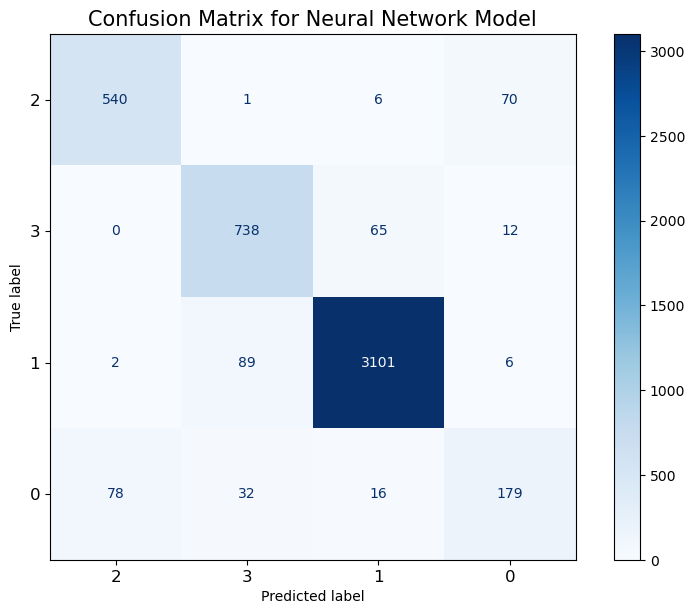

In [43]:
# Import necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the data
cell_labels = pbmc_hvg.obs['cell_types'].to_list()
classes = pbmc_hvg.obs["cell_types"].unique()

labelencoder = LabelEncoder()
cell_labels = labelencoder.fit_transform(cell_labels)
classes = labelencoder.fit_transform(classes)

X = reduced_matrix  # Features
y = cell_labels  # Target labels

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Create the neural network model
model = MLPClassifier(hidden_layer_sizes=(50), max_iter=500, activation='relu', solver='adam', random_state=42)

# Step 4: Train the model (fit it to the training data)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test data
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Optional: Print detailed classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Step 7: Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 8: Plot the confusion matrix with rotated and aligned labels
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size if needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to avoid cutting off labels
plt.tight_layout()

plt.title('Confusion Matrix for Neural Network Model', fontsize=15)
plt.show()